# B_b_2 : Obtenir les données - Données Météo

## Source : Open-Meteo : Free Weather API

> Open-Meteo is an open-source weather API and offers free access for non-commercial use. No API key is required. You can use it immediately!  
> Open-Meteo offers a diverse range of APIs that go beyond traditional weather forecasting. Explore a world of possibilities with our APIs for past weather data, ocean data, air quality, ensemble forecasts, climate forecasts based on IPCC predictions, and even floods. Whatever your weather-related needs may be, Open-Meteo has got you covered.

https://open-meteo.com/

Site consulté le : 2023-11-14

### Description

Deux API disponibles sur le site Open-Meteo nous interessent pour nous aider dans nos prédictions de la demande électrique.

1. **Historical Weather API** : Accès aux données historiques (jusqu'à 1940 si désiré). Les données historiques se termine *'il y a 5 jours'*.
2. **Forecast API** : API avec les 5 derniers jours et 16 prochains en prédiction

Les données sont disponibles pour un endroit précis, via ses coordonnées. Nous décidons de choisir **Montréal**, étant donné que c'est un lieu 'démographiquement' central. 

![Entrée des données pour l'API](../reports/figures/open_meteo_input.png)

Les données qui nous intéressent sont la température à 2m du sol. 

## Objectifs

Nous désirons bâtir un fichier d'historique, soit avant le 1er janvier 2019, en plus d'obtenir les données de prévision météo pour les 16 prochains jours, soit le maximum disponible selon le site. 

Ces deux fichiers seront regroupés pour avoir une série continue de données météo, qui nous permettront de créer des *features* et de faire les prévisions. 
 

In [3]:
%load_ext jupyter_black

# import black
# import jupyter_black

# jupyter_black.load(
#     lab=True,
#     line_length=55,
#     target_version=black.TargetVersion.PY311,
# )

In [70]:
import pandas as pd
import json
import httpx
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
from references.settings import colors_pal

## Import des prévisions météo

Nous allons effectuer un appel (*get*) sur l'API de prévisions du site afin d'obtenir les données futures. L'adresse URL utilisée est bâtie à partir du site web pour Montréal et possède les paramètres :

`hourly=temperature_2m  past_days=5  forecast_days=16`

In [11]:
# API avec les 5 derniers jours et 16 prochains en prédiction
prediction_url = "https://api.open-meteo.com/v1/forecast?latitude=45.5088&longitude=-73.5878&hourly=temperature_2m&timezone=America%2FNew_York&past_days=5&forecast_days=16"
r = httpx.get(prediction_url)
data_pred = json.loads(r.text)

In [14]:
df_pred = (
    pd.DataFrame.from_records(data_pred["hourly"])
    .rename(
        columns={
            "time": "date",
            "temperature_2m": "temp",
        }
    )
    .set_index("date")
)

df_pred.index = pd.to_datetime(df_pred.index)

df_pred

,temp
date,
2023-11-09 00:00:00,-0.6
2023-11-09 01:00:00,-0.8
2023-11-09 02:00:00,-0.8
2023-11-09 03:00:00,-1.2
2023-11-09 04:00:00,-1.4
...,...
2023-11-29 19:00:00,0.7
2023-11-29 20:00:00,0.5
2023-11-29 21:00:00,0.3


Nous pouvons voir que nous avons le même format de date - heure que nous avons utilisé précédemment avec les demandes électriques. 

La date de début est le 9 novembre, soit il y a 5 jours pour la date d'aujourd'hui (14 novembre) et va 15 jours + 23 heures dans le futur.

Nous pouvons effectuer une visualisation. 

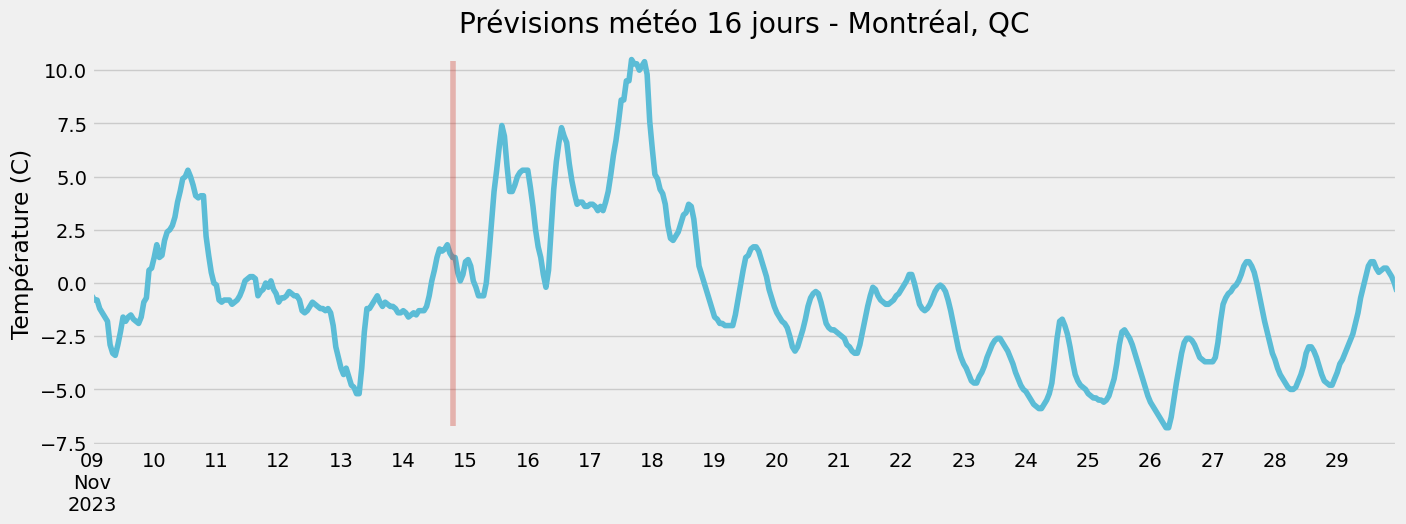

In [33]:
df_pred.plot(
    style="-",
    ms=1.0,
    figsize=(15, 5),
    title="Prévisions météo 16 jours - Montréal, QC",
    xlabel="",
    ylabel="Température (C)",
    legend=False,
    color=colors_pal[4],
)

plt.axvline(
    x=datetime.now(),
    ymin=0.05,
    ymax=0.95,
    color=colors_pal[6],
    alpha=0.3,
)

plt.show()

## Historique des données

Nous nous intéressons aussi aux données historiques de la température.  Notre ensemble de données de la demande électrique commence le 1er janvier 2019, mais nous pouvons prévoir une année précédente pour être en mesure de calculer les moyennes mobiles, etc.. 

In [35]:
date_dep: str = "2018-01-01"
date_fin: str = str(df_pred.index.min().date())

hist_url: str = f"https://archive-api.open-meteo.com/v1/archive?latitude=45.5088&longitude=-73.5878&start_date={date_dep}&end_date={date_fin}&hourly=temperature_2m&timezone=America%2FNew_York"

r = httpx.get(hist_url)
data_hist = json.loads(r.text)

In [37]:
df_hist = (
    pd.DataFrame.from_records(data_hist["hourly"])
    .rename(
        columns={
            "time": "date",
            "temperature_2m": "temp",
        }
    )
    .set_index("date")
)

df_hist.index = pd.to_datetime(df_hist.index)

In [38]:
df_hist

,temp
date,
2018-01-01 00:00:00,-24.4
2018-01-01 01:00:00,-24.9
2018-01-01 02:00:00,-25.1
2018-01-01 03:00:00,-25.3
2018-01-01 04:00:00,-25.6
...,...
2023-11-09 19:00:00,1.2
2023-11-09 20:00:00,1.4
2023-11-09 21:00:00,2.4


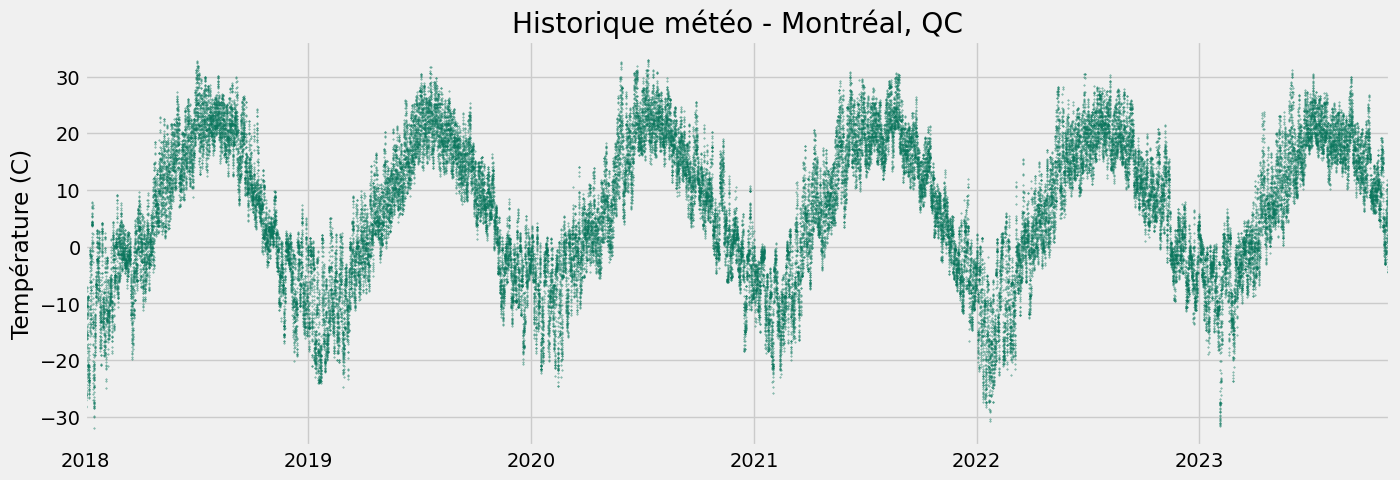

In [54]:
df_hist.plot(
    style=".",
    ms=0.7,
    figsize=(15, 5),
    title="Historique météo - Montréal, QC",
    xlabel="",
    ylabel="Température (C)",
    legend=False,
    color=colors_pal[9],
    alpha=0.8,
)
plt.show()

## Validation du point de rencontre

In [58]:
valid = pd.merge(
    df_hist,
    df_pred,
    how="outer",
    left_index=True,
    right_index=True,
)

In [86]:
valid[
    df_pred.index.min()
    - timedelta(hours=10) : df_hist.index.max()
    + timedelta(hours=5)
]

,temp_x,temp_y
date,,
2023-11-08 14:00:00,2.6,NaN
2023-11-08 15:00:00,2.6,NaN
2023-11-08 16:00:00,1.7,NaN
2023-11-08 17:00:00,0.8,NaN
2023-11-08 18:00:00,-1.3,NaN
2023-11-08 19:00:00,-1.0,NaN
2023-11-08 20:00:00,-1.8,NaN
2023-11-08 21:00:00,-1.7,NaN
2023-11-08 22:00:00,-1.4,NaN


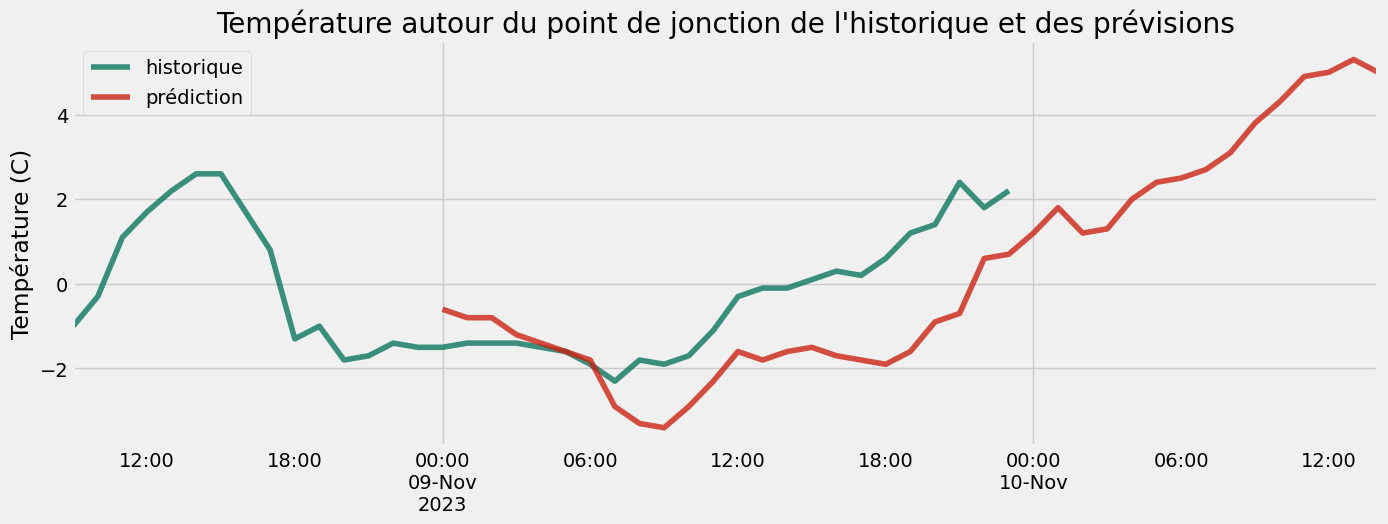

In [82]:
valid[
    df_pred.index.min()
    - timedelta(hours=15) : df_hist.index.max()
    + timedelta(hours=15)
].rename(
    columns={
        "temp_x": "historique",
        "temp_y": "prédiction",
    }
).plot(
    figsize=(15, 5),
    title="Température autour du point de jonction de l'historique et des prévisions",
    xlabel="",
    ylabel="Température (C)",
    style="-",
    ms=1.5,
    color=[colors_pal[9], colors_pal[6]],
    alpha=0.8,
)
plt.show()

Nous pouvons voir que les données ne sont pas à 100% alignées au point de jonction. Nous pouvons en faire la moyenne afin de lisser ce point. La moyenne ne prend pas en compte les valeurs NaN, donc nous pouvons l'appliquer sur tout le df.

In [91]:
valid["moyenne"] = valid.mean(axis=1)

In [90]:
valid

,temp_x,temp_y,moyenne
date,,,
2018-01-01 00:00:00,-24.4,NaN,-24.4
2018-01-01 01:00:00,-24.9,NaN,-24.9
2018-01-01 02:00:00,-25.1,NaN,-25.1
2018-01-01 03:00:00,-25.3,NaN,-25.3
2018-01-01 04:00:00,-25.6,NaN,-25.6
...,...,...,...
2023-11-29 19:00:00,NaN,0.7,0.7
2023-11-29 20:00:00,NaN,0.5,0.5
2023-11-29 21:00:00,NaN,0.3,0.3


Si nous reprenons la visualiation :

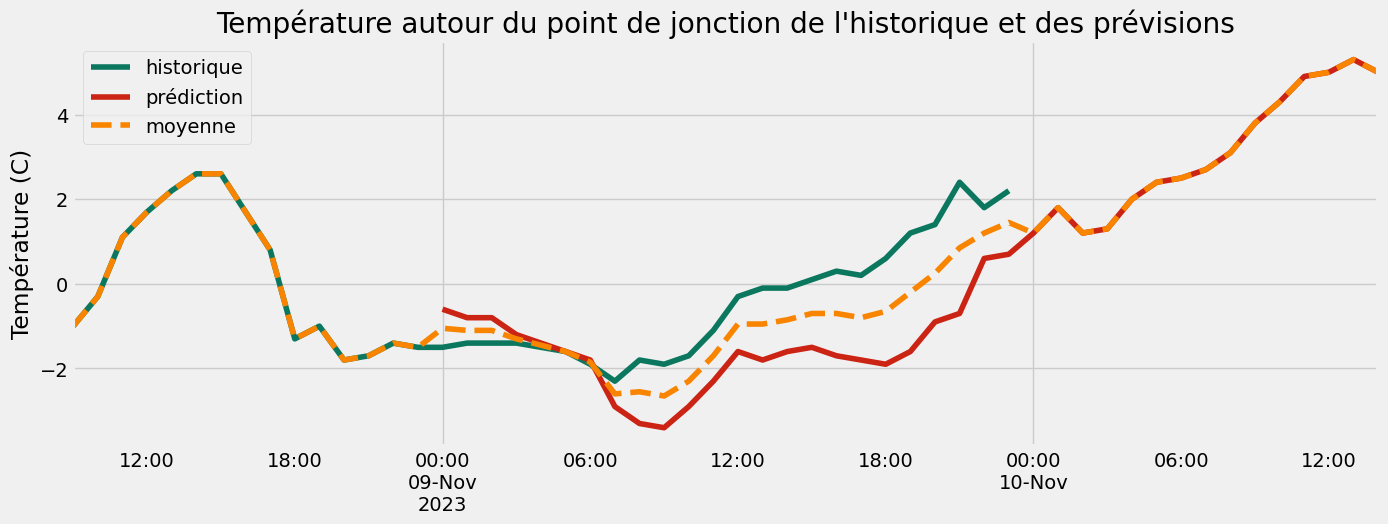

In [99]:
valid[
    df_pred.index.min()
    - timedelta(hours=15) : df_hist.index.max()
    + timedelta(hours=15)
].rename(
    columns={
        "temp_x": "historique",
        "temp_y": "prédiction",
    }
).plot(
    figsize=(15, 5),
    title="Température autour du point de jonction de l'historique et des prévisions",
    xlabel="",
    ylabel="Température (C)",
    style=["-", "-", "--"],
    ms=1.2,
    color=[
        colors_pal[9],
        colors_pal[6],
        colors_pal[3],
    ],
)
plt.show()

Nous voyons bien que la moyenne vient lisser la différences de température sur ces quelques heures.  Nous la conservons pour la suite au lieu des températures prédites et historiques. 

In [113]:
df = valid.drop(columns=["temp_x", "temp_y"]).rename(
    columns={"moyenne": "temp"}
)

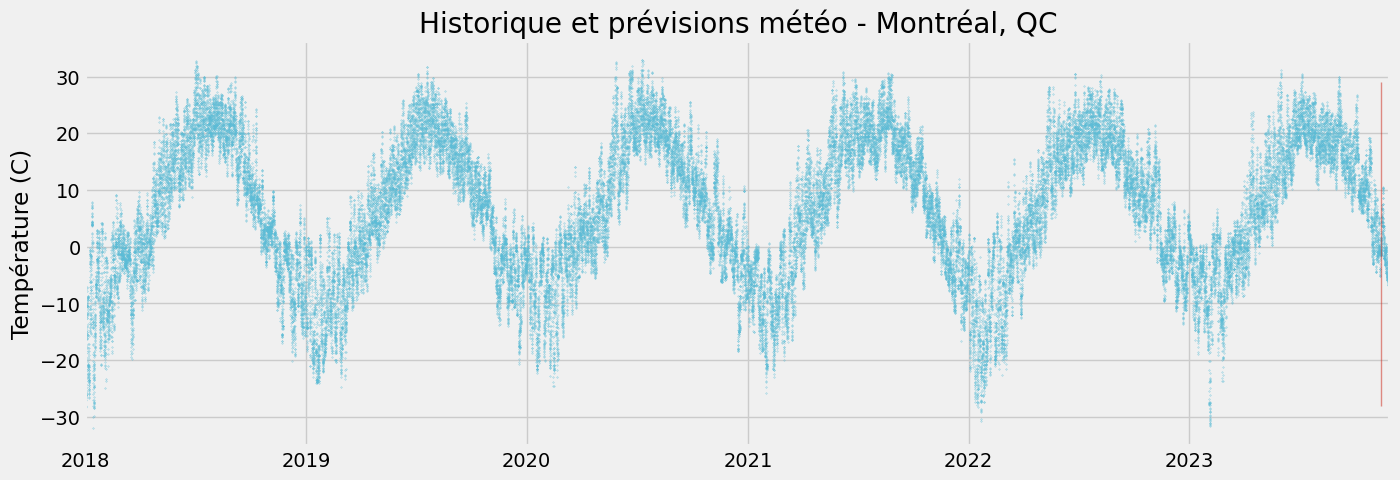

In [112]:
df.plot(
    style=".",
    ms=0.5,
    figsize=(15, 5),
    title="Historique et prévisions météo - Montréal, QC",
    xlabel="",
    ylabel="Température (C)",
    legend=False,
    color=colors_pal[4],
)

plt.axvline(
    linewidth=1,
    x=datetime.now(),
    ymin=0.1,
    ymax=0.9,
    color=colors_pal[6],
    alpha=0.5,
)

plt.show()

Nous avons maintenant une série de données en continu que nous pourrons utiliser pour la suite de l'étude, ce qui répond au besoin de cette partie de l'obtention de données.  

Nous allons regrouper toutes les fonctions d'import, de nettoyage et la création du fichier parquet et d'un graphique directement dans le script du dossier `src/data/hist_prev_meteo.py`

## Pipeline de donnnées

Nous allons ajouter cette opération au *workflow* existant sur [github actions](https://docs.github.com/en/actions) pour les données quotidiennes de demande électrique. De cette manière, nous aurons toujours un fichier de météo à jour dans notre dossier. 

# Résumé 

Dans ce notebook, nous avons :

- importé les données des données prévisionnelles et historiques de la température de l'air à Montréal à partir d'un API publique ;   
- effectué une visualisation des données importées ;
- validé l'intégrité des données au point de jonction entre l'historique et les prévisions ;
- trouvé une solution pour rendre ces données continues à cet endroit ;
- sauvegardé ces données intérimaires en un format parquet, que nous allons réutiliser subséquemment ;
- créé un pipeline de données dans le dossier `src/data`, afin d'automatiser toute cette partie ;
- créé un pipeline automatique quotidien avec github action

Nous notons aussi que cette approche pourra être utilisée dans le futur pour joindre les données historiques et quotidiennes de demande électrique, étant donné que le même genre de problème est successible de survenir. 